# Clustering and functional enrichment analysis of ciliary intensity profiles

Author: Konstantin Kahnert  
Date: 2025-04-17  
Description: Clustering and functional enrichment analysis of ciliary intensity profiles. The intensity profiles were calculated by 
Huangqingbo (Paul) Sun as described in this script: HPA_Cilia_Study_Code/Cilia profile analysis/main_stream_revision.py

# Load packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy
import scanpy as sc
import pickle

from anndata import AnnData
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn import cluster
from gprofiler import GProfiler

# don't show warnings
import warnings
warnings.filterwarnings("ignore")

# Data wrangling

## Load data

In [2]:
# Code to load and process intesity profiles adapted from Huangqingbo (Paul) Sun's notebook cilia_profile_analysis.ipynb

# Load new intensity profiles & thresholds
intensity_profiles = pickle.load(
    open(
        "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/intensity_profiles_A_all.pkl",
        "rb",
    )
)
thresholds = pickle.load(
    open(
        "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/thresholds_all.pkl",
        "rb",
    )
)

# Initialize a list to store the processed intensity profiles
intensity_profiles_list = []

# Paul’s updated processing loop 
for key in intensity_profiles:
    # Skip empty intensity profiles
    if len(intensity_profiles[key]) == 0:
        continue

    # To array
    arr = np.array(intensity_profiles[key])

    # Subtract thresholds (per-row), clip negatives to zero
    for i in range(arr.shape[0]):
        arr[i] = arr[i] - thresholds[key][i]
    arr[arr < 0] = 0

    # Normalize so that the maximum is at least 15000
    max_val = max(15000, np.max(arr))
    arr = arr / max_val

    # Put it back
    intensity_profiles[key] = arr


# Load metadata & initialize containers 
df = pd.read_excel("/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/Filtered_Staining_List.xlsx", header=0)

cell_line_list = []
gene_names = []
plate_id_list = []
ensembl_ids = []

cilia_lengths = pickle.load(
    open(
        "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/cilia_lengths_all.pkl",
        "rb",
    )
)
cilia_lengths_list = []

subcellular_locations = pickle.load(
    open(
        "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/annotations_all.pkl",
        "rb",
    )
)
subcellular_locations_list = []

# Track any keys missing from the staining list
missing_keys = []

# Collect relevant data for each intensity profile 
for key in intensity_profiles:
    plate_id = int(key.split("_")[0])
    well_id = key.split("_")[1]

    row = df[(df["Plate id"] == plate_id) & (df["Position"] == well_id)]
    if row.empty:
        missing_keys.append(key)
        continue

    cell_line = row["Cell line"].values[0]
    gene_name = row["Gene name"].values[0]
    ensembl_id = row["Ensembl id"].values[0]

    # Append one entry per profile
    for profile in intensity_profiles[key]:
        intensity_profiles_list.append(profile)
        cell_line_list.append(cell_line)
        gene_names.append(gene_name)
        plate_id_list.append(plate_id)
        ensembl_ids.append(ensembl_id)

    # Append matching cilia lengths and subcellular locations
    for length in cilia_lengths.get(key, []):
        cilia_lengths_list.append(length)
    for loc in subcellular_locations.get(key, []):
        subcellular_locations_list.append(loc)

# Convert to array, smooth, and replace NaNs
intensity_profiles = np.array(intensity_profiles_list)
intensity_profiles = scipy.ndimage.gaussian_filter1d(
    intensity_profiles, axis=1, sigma=8
)
intensity_profiles = np.nan_to_num(intensity_profiles)


## Map cilia locations

### Load ciliary‑location annotation table

In [3]:
# Load location‐annotation table (Ensembl ID ↔ ciliary sub‑locations)
LOC_FILE = (
    "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/"
    "revision/All_files_combined_as_cytoscape_input.csv"
)

df_locs = (
    pd.read_csv(LOC_FILE, sep="\t")
      .set_index("All analyzed proteins")        
)

print(f"Location table shape: {df_locs.shape}")


Location table shape: (1360, 27)


### Extract & align ciliary sub‑location flags to ensembl_ids order

In [4]:
# List of location columns that we need downstream
LOCATION_COLS = [
    # ASC52telo
    "BasalBody_ASC52telo", "PrimaryCilia_ASC52telo",
    "PrimaryCiliaTZ_ASC52telo", "PrimaryCiliaTip_ASC52telo",
    # hTERT‑RPE1 (serum starved)
    "BasalBody_hTERT_RPE1_serum_starved", "PrimaryCilia_hTERT_RPE1_serum_starved",
    "PrimaryCiliaTZ_hTERT_RPE1_serum_starved", "PrimaryCiliaTip_hTERT_RPE1_serum_starved",
    # RPTEC‑TERT1
    "BasalBody_RPTEC_TERT1", "PrimaryCilia_RPTEC_TERT1",
    "PrimaryCiliaTZ_RPTEC_TERT1", "PrimaryCiliaTip_RPTEC_TERT1",
]

# Align the table to the sample order in `ensembl_ids`
# IDs that are missing in `df_locs` become all‑False rows.
loc_df = (
    df_locs[LOCATION_COLS]               # keep only relevant columns
      .reindex(ensembl_ids)              # order as in `ensembl_ids`
      .fillna(0)                         # missing IDs → 0/False
      .astype(bool)                      # ensure boolean dtype
)


### Create AnnData object from embeddings and add metadata

In [5]:
# Create AnnData object from embeddings
adata = AnnData(X=intensity_profiles)

# Core sample annotations
adata.obs["ensembl_id"]            = ensembl_ids
adata.obs["cell_line"]             = cell_line_list
adata.obs["gene_name"]             = gene_names
adata.obs["cilia_length"]          = cilia_lengths_list
adata.obs["plate_id"]              = plate_id_list
adata.obs["subcellular_location"]  = subcellular_locations_list

# Concatenate location flags (order preserved)
adata.obs = pd.concat(
    [adata.obs.reset_index(drop=True), loc_df.reset_index(drop=True)],
    axis=1
)


### Aggregate cilia‑presence flags per cell line and overall

In [6]:
# Groups of columns that belong together
GROUPS = {
    "ASC52telo": [
        "BasalBody_ASC52telo", "PrimaryCilia_ASC52telo",
        "PrimaryCiliaTZ_ASC52telo", "PrimaryCiliaTip_ASC52telo",
    ],
    "hTERT_RPE1_serum_starved": [
        "BasalBody_hTERT_RPE1_serum_starved", "PrimaryCilia_hTERT_RPE1_serum_starved",
        "PrimaryCiliaTZ_hTERT_RPE1_serum_starved", "PrimaryCiliaTip_hTERT_RPE1_serum_starved",
    ],
    "RPTEC_TERT1": [
        "BasalBody_RPTEC_TERT1", "PrimaryCilia_RPTEC_TERT1",
        "PrimaryCiliaTZ_RPTEC_TERT1", "PrimaryCiliaTip_RPTEC_TERT1",
    ],
}

# Sum boolean flags within each cell‑line group
for grp, cols in GROUPS.items():
    adata.obs[f"cilia_{grp}"] = adata.obs[cols].sum(axis=1).astype(bool)

# Overall presence across all three cell lines
adata.obs["cilia"] = adata.obs[[f"cilia_{g}" for g in GROUPS]].sum(axis=1).astype(bool)


### Summarize sub‑location counts and assign mono‑/multi‑location labels

In [7]:
for grp, cols in GROUPS.items():
    sum_col  = f"loc_sum_{grp}"
    mono_col = f"location_mono_{grp}"

    # How many distinct ciliary sub‑locations are positive?
    adata.obs[sum_col] = adata.obs[cols].astype(int).sum(axis=1)

    # Classify each protein:
    #    • >1 positive  → "multiple"
    #    • exactly one  → name of that location (BB / PC / TZ / tip)
    #    • none         → "None"
    conditions = [
        adata.obs[sum_col] > 1,
        adata.obs[cols[0]],
        adata.obs[cols[1]],
        adata.obs[cols[2]],
        adata.obs[cols[3]],
    ]
    choices = ["multiple", "BB", "PC", "TZ", "tip"]

    adata.obs[mono_col] = np.select(conditions, choices, default="None")

# Quick inspection
adata.obs.head()


,ensembl_id,cell_line,gene_name,cilia_length,plate_id,subcellular_location,BasalBody_ASC52telo,PrimaryCilia_ASC52telo,PrimaryCiliaTZ_ASC52telo,PrimaryCiliaTip_ASC52telo,...,cilia_ASC52telo,cilia_hTERT_RPE1_serum_starved,cilia_RPTEC_TERT1,cilia,loc_sum_ASC52telo,location_mono_ASC52telo,loc_sum_hTERT_RPE1_serum_starved,location_mono_hTERT_RPE1_serum_starved,loc_sum_RPTEC_TERT1,location_mono_RPTEC_TERT1
0,ENSG00000101557,hTERT-RPE1 (serum starved),USP14,7.469324,2151,"[ER, Plasma membrane]",False,False,False,False,...,False,False,False,False,0,None,0,None,0,None
1,ENSG00000101557,hTERT-RPE1 (serum starved),USP14,2.959328,2151,"[ER, Plasma membrane]",False,False,False,False,...,False,False,False,False,0,None,0,None,0,None
2,ENSG00000101557,hTERT-RPE1 (serum starved),USP14,5.287883,2151,"[ER, Plasma membrane]",False,False,False,False,...,False,False,False,False,0,None,0,None,0,None
3,ENSG00000101557,hTERT-RPE1 (serum starved),USP14,4.050331,2151,"[ER, Plasma membrane]",False,False,False,False,...,False,False,False,False,0,None,0,None,0,None
4,ENSG00000101557,hTERT-RPE1 (serum starved),USP14,8.425824,2151,"[ER, Plasma membrane]",False,False,False,False,...,False,False,False,False,0,None,0,None,0,None


## Remove all 0 rows and constant rows

In [8]:
# Check for zero vectors and remove them
zero_vector_mask = np.all(adata.X == 0, axis=1)

# add as column
adata.obs["zero_vector"] = zero_vector_mask

if np.any(zero_vector_mask):
    print(f"Found {np.sum(zero_vector_mask)} zero vectors. Removing them.")
    adata = adata[adata.obs["zero_vector"] == False].copy()

# Check for constant rows (zero variance)
constant_rows = np.var(adata.X, axis=1) == 0
if np.any(constant_rows):
    print(f"Found {np.sum(constant_rows)} constant rows. Removing them.")
    adata = adata[~constant_rows].copy()

Found 1205 zero vectors. Removing them.
Found 42 constant rows. Removing them.


## Split by cell line

In [9]:
# filter by cell line
adata_ASC52telo = adata[adata.obs["cell_line"] == "ASC52telo"]
adata_hTERT_RPE1_serum_starved = adata[
    adata.obs["cell_line"] == "hTERT-RPE1 (serum starved)"
]
adata_RPTEC_TERT1 = adata[adata.obs["cell_line"] == "RPTEC/TERT1"]

# print shapes
print(adata_ASC52telo.shape)
print(adata_hTERT_RPE1_serum_starved.shape)
print(adata_RPTEC_TERT1.shape)

(7186, 100)
(48678, 100)
(24161, 100)


# RPTEC/TERT1

## Avergage profiles per protein

### Remove proteins that are not in cilia

In [10]:
print(adata_RPTEC_TERT1.shape)

# remove proteins that are not in cilia
adata_RPTEC_TERT1 = adata_RPTEC_TERT1[adata_RPTEC_TERT1.obs["loc_sum_RPTEC_TERT1"] != 0]

print(adata_RPTEC_TERT1.shape)

(24161, 100)
(13405, 100)


### Visualize standard deviation per protein

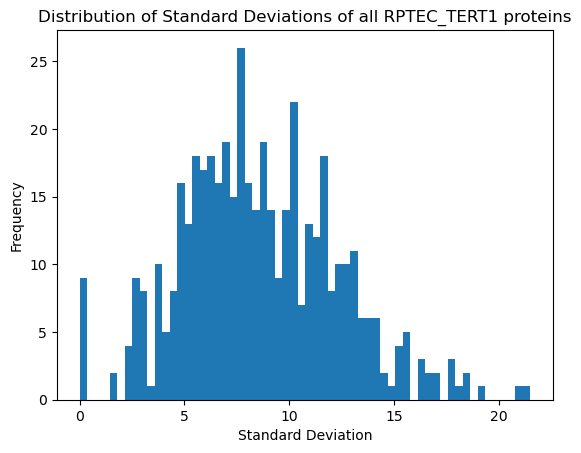

In [11]:
# Convert the AnnData object corresponding to RPTEC TERT1 to a DataFrame
df = pd.DataFrame(adata_RPTEC_TERT1.X, columns=adata_RPTEC_TERT1.var_names)

# Add a column for Ensembl IDs to the DataFrame
df["ensembl_id"] = adata_RPTEC_TERT1.obs["ensembl_id"].values

# Group the DataFrame by Ensembl ID, calculate the standard deviation for each group, and sum the results across all variables
df_tmp = df.groupby("ensembl_id").std().sum(axis=1)

# Plot a histogram of the summed standard deviations
plt.hist(df_tmp, bins=60)  # Create a histogram with specified number of bins

# add axis labels
plt.xlabel("Standard Deviation")  # X-axis label
plt.ylabel("Frequency")  # Y-axis label
plt.title("Distribution of Standard Deviations of all RPTEC_TERT1 proteins")  # Title of the histogram

plt.show()  # Display the histogram

### Remove proteins with high standard deviation and aggregate to protein level

In [12]:
# Convert the AnnData object corresponding to RPTEC TERT1 to a DataFrame
df = pd.DataFrame(adata_RPTEC_TERT1.X, columns=adata_RPTEC_TERT1.var_names)

# Add a column for Ensembl IDs to the DataFrame
df["ensembl_id"] = adata_RPTEC_TERT1.obs["ensembl_id"].values

# Uncomment the following lines to filter for proteins with low standard deviation between profiles
# Calculate the standard deviation for each Ensembl ID, summing across all variables
df_tmp = df.groupby("ensembl_id").std().sum(axis=1)

# Filter groups where the summed standard deviation is less than a threshold
df_tmp = df_tmp[df_tmp < 20]

# Keep only those proteins in the original DataFrame that meet the standard deviation criterion
num_ids_before = len(df["ensembl_id"].unique())
df = df[df["ensembl_id"].isin(df_tmp.index)]
num_ids_after = len(df["ensembl_id"].unique())

# print how many proteins were removed
print(f"Removed {num_ids_before - num_ids_after} proteins with high standard deviation.")

# Group by the Ensembl ID and compute the mean intensity for each group
df_grouped = df.groupby("ensembl_id").mean()

# Create a new AnnData object with the aggregated mean data
adata_RPTEC_TERT1_agg = AnnData(
    X=df_grouped.values,  # Values (means) as the main data
    var=adata_RPTEC_TERT1.var_names.values,  # Variable names from the original AnnData
    obs=pd.DataFrame(
        df_grouped.index
    ),  # Observation (indices) from the grouped DataFrame
)

# Prepare to map the subcellular location and other metadata to the aggregated data
df_unique = adata_RPTEC_TERT1.obs.drop_duplicates(
    subset="ensembl_id", keep="first"
).set_index(
    "ensembl_id"
)  # Select unique rows based on Ensembl ID

# Merge the aggregated observation data with the unique metadata based on Ensembl IDs
adata_RPTEC_TERT1_agg.obs = adata_RPTEC_TERT1_agg.obs.merge(
    df_unique, on="ensembl_id", how="left"
)

# Verify the shape of the original and aggregated AnnData objects
print(f"Original shape: {adata_RPTEC_TERT1.shape}")  # Print the shape of original data
print(
    f"Aggregated shape: {adata_RPTEC_TERT1_agg.shape}"
)  # Print the shape of aggregated data

Removed 2 proteins with high standard deviation.
Original shape: (13405, 100)
Aggregated shape: (455, 100)


### Check again for 0 rows and constant rows and remove them

In [13]:
# Check for zero vectors in the aggregated AnnData object
zero_vector_mask = np.all(
    adata_RPTEC_TERT1_agg.X == 0, axis=1
)  # Mask for rows where all elements are zero

# Add a column "zero_vector" to the observation DataFrame indicating whether each vector is zero
adata_RPTEC_TERT1_agg.obs["zero_vector"] = zero_vector_mask

# If any zero vectors are found, print the count and remove them from the AnnData object
if np.any(zero_vector_mask):
    print(f"Found {np.sum(zero_vector_mask)} zero vectors. Removing them.")
    adata_RPTEC_TERT1_agg = adata_RPTEC_TERT1_agg[
        ~adata_RPTEC_TERT1_agg.obs["zero_vector"]  # Keep rows that are not zero vectors
    ]

# Check for constant rows (i.e., rows with no variance, which means every value is the same)
constant_rows = (
    np.var(adata_RPTEC_TERT1_agg.X, axis=1) == 0
)  # Mask for rows with zero variance

# If any constant rows are found, print the count and remove them from the AnnData object
if np.any(constant_rows):
    print(f"Found {np.sum(constant_rows)} constant rows. Removing them.")
    adata_RPTEC_TERT1_agg = adata_RPTEC_TERT1_agg[
        ~constant_rows
    ]  # Keep rows that are not constant

In [14]:
len(adata_RPTEC_TERT1_agg.obs["ensembl_id"].unique())

455

### Scale each profile between 0-1 (max scaled)

In [15]:
# Create a copy of the aggregated AnnData object to avoid modifying the original data
adata_agg_RPTEC_TERT1_scaled = adata_RPTEC_TERT1_agg.copy()

# Scale each row (profile) of the AnnData object so that its values range from 0 to 1
# This is done by dividing each element in the row by the maximum value of that row
adata_agg_RPTEC_TERT1_scaled.X = (
    adata_RPTEC_TERT1_agg.X / adata_RPTEC_TERT1_agg.X.max(axis=1)[:, None]
)

In [16]:
# set input data
cilia_profiles = adata_agg_RPTEC_TERT1_scaled.X

## Determine number of clusters for range of cutoffs


Found 455 clusters for cutoff 0.00.
Found 187 clusters for cutoff 0.05.
Found 82 clusters for cutoff 0.10.
Found 36 clusters for cutoff 0.15.
Found 20 clusters for cutoff 0.20.
Found 12 clusters for cutoff 0.25.
Found 7 clusters for cutoff 0.30.
Found 5 clusters for cutoff 0.35.
Found 2 clusters for cutoff 0.40.
Found 2 clusters for cutoff 0.45.
Found 1 clusters for cutoff 0.50.
Found 1 clusters for cutoff 0.55.
Found 1 clusters for cutoff 0.60.
Found 1 clusters for cutoff 0.65.
Found 1 clusters for cutoff 0.70.
Found 1 clusters for cutoff 0.75.
Found 1 clusters for cutoff 0.80.
Found 1 clusters for cutoff 0.85.
Found 1 clusters for cutoff 0.90.
Found 1 clusters for cutoff 0.95.


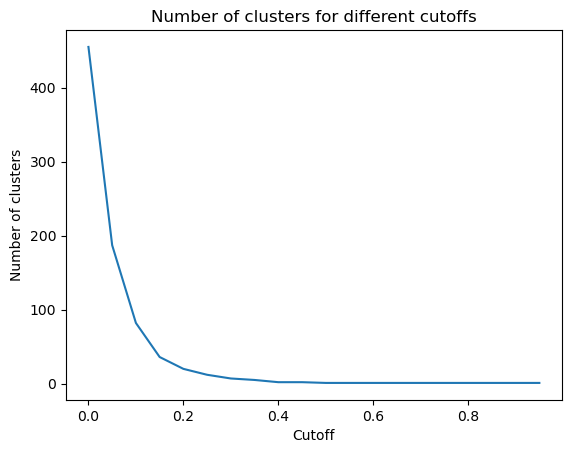

In [17]:
# Calculate the pairwise distance matrix using the Euclidean metric
distance_matrix = pdist(cilia_profiles, metric="euclidean")

# Perform hierarchical clustering using the average linkage method and Euclidean distance metric
linkage_matrix = linkage(
    cilia_profiles, method="average", metric="euclidean", optimal_ordering=False
)

# Scale the distance matrix to the range [0, 1]
distance_matrix_scaled = (distance_matrix - distance_matrix.min()) / (
    distance_matrix.max() - distance_matrix.min()
)

# Convert the scaled distance matrix to a square form
distance_matrix_square = squareform(distance_matrix_scaled)

# Initialize lists to store the number of clusters and labels for each cutoff
n_clusters = []
labels = {}

# Iterate through a range of cutoff thresholds to determine the number of clusters
for cutoff in np.arange(0, 1.0, 0.05):
    # Initialize the Agglomerative Clustering model with the specified parameters
    clusterer = cluster.AgglomerativeClustering(
        metric="precomputed",
        distance_threshold=cutoff,
        n_clusters=None,
        linkage="average",
    )

    # Fit the clustering model to the distance matrix
    clusterer.fit(distance_matrix_square)

    # Store the cluster labels and number of unique clusters for the current cutoff
    labels[f"{cutoff:.2f}"] = clusterer.labels_
    n_clusters.append(len(np.unique(clusterer.labels_)))
    print(f"Found {n_clusters[-1]} clusters for cutoff {cutoff:.2f}.")

# Plot the number of clusters for different cutoff thresholds
plt.plot(np.arange(0, 1.0, 0.05), n_clusters)
plt.xlabel("Cutoff")
plt.ylabel("Number of clusters")
plt.title("Number of clusters for different cutoffs")
plt.show()

## Cluster based on selected cutoff

In [18]:
# Set the cutoff threshold for clustering
cutoff = 0.16

# Initialize the Agglomerative Clustering model with the specified cutoff
clusterer = cluster.AgglomerativeClustering(
    metric="precomputed", distance_threshold=cutoff, n_clusters=None, linkage="average"
)

# Fit the clustering model to the distance matrix
clusterer.fit(distance_matrix_square)

# Retrieve the cluster labels
clusters = clusterer.labels_

# Count the number of unique clusters formed
n_clusters = len(np.unique(clusters))
print(f"Found {n_clusters} clusters for cutoff {cutoff}.")

Found 32 clusters for cutoff 0.16.


## Visualize clusters and heatmaps

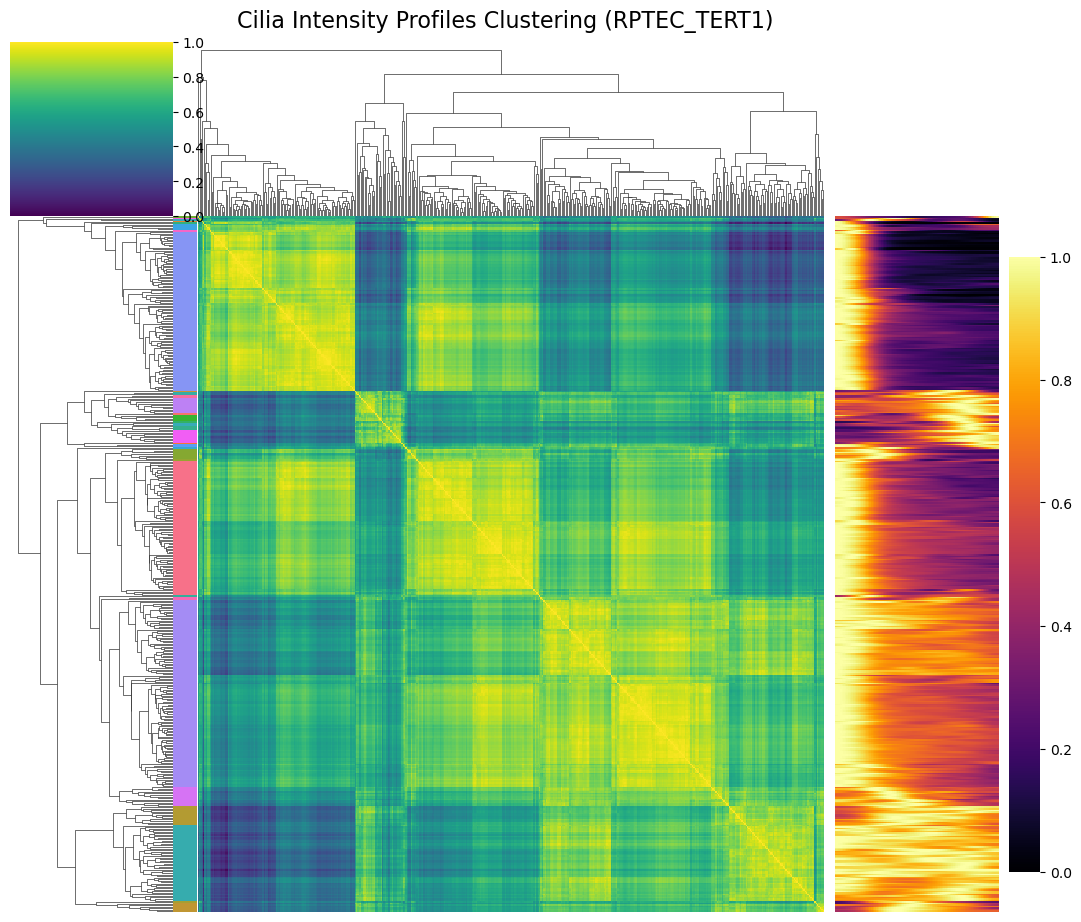

In [19]:
# Prepare vector with colors for each cluster
colors = sns.color_palette(
    "husl", n_clusters
)  # Generate a color palette with n_clusters colors
np.random.shuffle(colors)  # Shuffle the colors to randomize them
cluster_colors = [
    colors[cluster - 1] for cluster in clusters
]  # Assign colors to clusters

# Get the dendrogram order
dendro = dendrogram(linkage_matrix, no_plot=True)
dendro_order = dendro["leaves"]

# Reorder the matrix according to the dendrogram order
reordered_matrix = cilia_profiles[dendro_order, :]

# Create the first clustermap with row and column linkage
g = sns.clustermap(
    1 - distance_matrix_square,  # Plot the inverse of the distance matrix
    row_linkage=linkage_matrix,  # Use the precomputed row linkage
    col_linkage=linkage_matrix,  # Use the precomputed column linkage
    cmap="viridis",  # Use 'viridis' colormap
    row_colors=cluster_colors,  # Add colors to rows according to clusters
    xticklabels=False,  # Hide x-axis labels
    yticklabels=False,  # Hide y-axis labels
    figsize=(11, 9),  # Set figure size
    cbar_pos=(0.02, 0.8, 0.05, 0.1),  # Set colorbar position
)

# Set the gridspec to only cover a portion of the figure
g.gs.update(left=0.05, right=0.79)

# Create new gridspec for the right part of the figure
gs2 = mpl.gridspec.GridSpec(1, 1, left=0.8, top=0.79)

# Create axes within this new gridspec
ax2 = g.fig.add_subplot(gs2[0])

# Plot the second heatmap on the new axis
sns.heatmap(
    reordered_matrix,
    cmap="inferno",  # Use 'inferno' colormap
    cbar=True,  # Show colorbar
    xticklabels=False,  # Hide x-axis labels
    yticklabels=False,  # Hide y-axis labels
    ax=ax2,  # Specify the axis to plot on
)

# Set the title of the figure
plt.suptitle(
    "Cilia Intensity Profiles Clustering (RPTEC_TERT1)", fontsize=16, y=1.02
)  

# Save the figure as an SVG image
plt.savefig(
    "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/RPTEC_TERT1_agg_clustered.svg"
)

# Adjust layout to ensure both plots have the same height
plt.show()

## Plot without clustermap

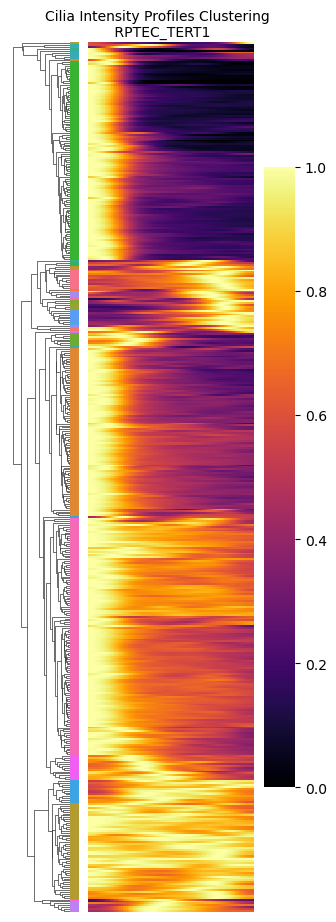

In [20]:
# Prepare a vector with colors for each cluster
colors = sns.color_palette(
    "husl", n_clusters
)  # Generate a color palette with n_clusters colors
np.random.shuffle(colors)  # Randomly shuffle the colors
cluster_colors = [
    colors[cluster - 1] for cluster in clusters
]  # Assign colors to clusters

# Get the order of rows for the dendrogram
dendro = dendrogram(linkage_matrix, no_plot=True)
dendro_order = dendro["leaves"]

# Reorder the cilia profiles matrix according to the dendrogram order
reordered_matrix = cilia_profiles[dendro_order, :]

# Create a clustermap with only the row dendrogram and row colors
g = sns.clustermap(
    1 - distance_matrix_square,  # Plot the inverse of the distance matrix
    row_linkage=linkage_matrix,  # Use the precomputed row linkage
    col_cluster=False,  # Disable column clustering
    cmap="viridis",  # Use 'viridis' colormap
    row_colors=cluster_colors,  # Add colors to rows according to clusters
    xticklabels=False,  # Hide x-axis labels
    yticklabels=False,  # Hide y-axis labels
    figsize=(6, 9),  # Set figure size
    cbar_pos=None,  # Disable the colorbar
    dendrogram_ratio=(0.2, 0.0),  # Set column dendrogram ratio to 0
    colors_ratio=(0.03, 0.0),  # Set column colors ratio to 0
)

# Remove the heatmap axis from the clustermap
g.ax_heatmap.remove()

# Set the gridspec to only cover a portion of the figure
g.gs.update(left=0.5, right=1)

# Create a new gridspec for the right part of the figure
gs2 = mpl.gridspec.GridSpec(1, 1, left=0.63)

# Create axes within this new gridspec
ax2 = g.fig.add_subplot(gs2[0])

# Plot the second heatmap on the new axis
sns.heatmap(
    reordered_matrix,  # Use the reordered matrix
    cmap="inferno",  # Use 'inferno' colormap
    cbar=True,  # Show colorbar
    xticklabels=False,  # Hide x-axis labels
    yticklabels=False,  # Hide y-axis labels
    ax=ax2,  # Specify the axis to plot on
    linewidths=0,  # Remove grid lines
    linecolor="none",  # Remove grid line colors
)

# Set the title of the figure
plt.suptitle(
    "Cilia Intensity Profiles Clustering \n RPTEC_TERT1", fontsize=10, y=1.02, x=0.75 
)  

# Save the figure as an SVG image
plt.savefig(
    "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/RPTEC_TERT1_agg_clustered.svg",
    bbox_inches="tight",  # Ensure the entire plot is saved
)

# Save the figure as a high-resolution PNG image
plt.savefig(
    "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/RPTEC_TERT1_agg_clustered.png",
    bbox_inches="tight",  # Ensure the entire plot is saved
    dpi=1200,  # Set the resolution to 1200 DPI
)

# Adjust the layout to ensure both plots have the same height
plt.show()

## Count proteins in each cluster and add gene names to clusters

In [21]:
# Initialize an empty list to store cluster labels in dendrogram order
cluster_labels = []

# Append cluster labels according to the dendrogram order
for clstr in clusters[dendro_order]:
    cluster_labels.append(clstr)

# Convert the cluster labels into a DataFrame
df = pd.DataFrame(cluster_labels, columns=["cluster"])

# Count the number of proteins in each cluster
df_clusters = df["cluster"].value_counts(sort=False)

# Convert the series into a DataFrame and reset the index
df_clusters = df_clusters.reset_index()

# Rename the columns for clarity
df_clusters.columns = ["cluster", "protein_count"]

# Add a column containing the genes contained in each cluster
df_clusters["genes"] = df_clusters["cluster"].apply(
    lambda x: ", ".join(
        list(adata_RPTEC_TERT1_agg.obs["gene_name"].iloc[np.where(clusters == x)[0]])
    )
)

# Show dataframe
df_clusters

,cluster,protein_count,genes
0,15,1,MCHR2
1,19,1,CKAP2
2,25,1,SMG5
3,23,1,NECAB1
4,13,1,PTAFR
5,10,4,"PHLPP2, IFT52, CAMTA1, FFAR4"
6,28,1,SPICE1
7,14,104,"PRKAR2B, KATNIP, MPHOSPH9, CROCC, KIF2A, EVC, ..."
8,21,1,FAM149B1
9,9,2,"CLUAP1, LRRCC1"


## Perform functional enrichment analysis for clusters

In [22]:
# Initialize a dictionary to store enrichment results for each cluster
enrich_results = {}

# Iterate through each row in the df_clusters DataFrame
for idx, row in df_clusters.iterrows():

    # Skip clusters with fewer than 5 proteins
    if row["protein_count"] < 5:
        continue
    else:
        # Get the indices of the cluster
        cluster_indices = np.where(clusters == row["cluster"])[0]

        # Retrieve the corresponding protein names for the cluster
        protein_names = list(
            set(adata_RPTEC_TERT1_agg.obs["gene_name"].iloc[cluster_indices])
        )

        # Perform functional enrichment analysis using g:Profiler
        gp = GProfiler(return_dataframe=True)
        result = gp.profile(
            organism="hsapiens",  # Specify the organism as Homo sapiens
            query=protein_names,  # Input the list of protein names
            sources=[
                "GO:BP",
                "GO:MF",
            ],  # Specify GO Biological Process and Molecular Function
            no_evidences=False,  # Include evidence codes in the results
            user_threshold=0.05,  # Set the significance threshold for p-values
        )

        # Store the enrichment results for the current cluster
        enrich_results[row["cluster"]] = result

## Map enrichment results to DataFrame and save to .csv file

In [23]:
def join_with_semicolon(series):
    """Return the values of a Series joined by '; ' as strings."""
    return "; ".join(map(str, series))

# Summarize each cluster’s enrichment results in one row
summary_rows = []
for cluster_id, df in enrich_results.items():
    summary_rows.append(
        {
            "cluster":            cluster_id,
            "Ontology":           join_with_semicolon(df["source"]),
            "GO term name":       join_with_semicolon(df["name"]),
            "GO term ID":         join_with_semicolon(df["native"]),
            "GO term p values":   join_with_semicolon(df["p_value"]),
            "term_size":          join_with_semicolon(df["term_size"]),
            "query_size":         join_with_semicolon(df["query_size"]),
            "intersection_size":  join_with_semicolon(df["intersection_size"]),
            "precision":          join_with_semicolon(df["precision"]),
            "recall":             join_with_semicolon(df["recall"]),
        }
    )

summary_df = pd.DataFrame(summary_rows)

# Merge with the clustering table (adds new cols)
df_cluster_unique = df_clusters.copy() # save unmodified version for later
df_clusters = df_clusters.merge(summary_df, on="cluster", how="left")

# Clusters with no enrichment → empty strings
fill_cols = [
    "Ontology", "GO term name", "GO term ID", "GO term p values",
    "term_size", "query_size", "intersection_size",
    "precision", "recall"
]
df_clusters[fill_cols] = df_clusters[fill_cols].fillna("")


# Save the enriched clustering CSV
df_clusters.to_csv(
    "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/RPTEC_TERT1_agg_clustered_enriched.csv",
    index=False,
    sep="\t",
)

# Display the DataFrame
df_clusters


,cluster,protein_count,genes,Ontology,GO term name,GO term ID,GO term p values,term_size,query_size,intersection_size,precision,recall
0,15,1,MCHR2,,,,,,,,,
1,19,1,CKAP2,,,,,,,,,
2,25,1,SMG5,,,,,,,,,
3,23,1,NECAB1,,,,,,,,,
4,13,1,PTAFR,,,,,,,,,
5,10,4,"PHLPP2, IFT52, CAMTA1, FFAR4",,,,,,,,,
6,28,1,SPICE1,,,,,,,,,
7,14,104,"PRKAR2B, KATNIP, MPHOSPH9, CROCC, KIF2A, EVC, ...",GO:BP; GO:BP; GO:BP; GO:BP; GO:BP; GO:BP; GO:B...,microtubule-based process; cilium organization...,GO:0007017; GO:0044782; GO:0070925; GO:0060271...,6.1534153963199555e-28; 2.7332590061506443e-21...,959; 418; 998; 391; 663; 3570; 590; 603; 1615;...,100; 100; 100; 100; 100; 100; 100; 100; 100; 1...,43; 28; 37; 25; 30; 59; 28; 28; 40; 39; 38; 16...,0.43; 0.28; 0.37; 0.25; 0.3; 0.59; 0.28; 0.28;...,0.04483837330552659; 0.06698564593301436; 0.03...
8,21,1,FAM149B1,,,,,,,,,
9,9,2,"CLUAP1, LRRCC1",,,,,,,,,


# ASC52telo

## Avergage profiles per protein

### Remove proteins that are not in cilia

In [24]:
print(adata_ASC52telo.shape)

# remove proteins that are not in cilia
adata_ASC52telo = adata_ASC52telo[adata_ASC52telo.obs["loc_sum_ASC52telo"] != 0]

print(adata_ASC52telo.shape)

(7186, 100)
(2679, 100)


### Visualize standard deviation per protein

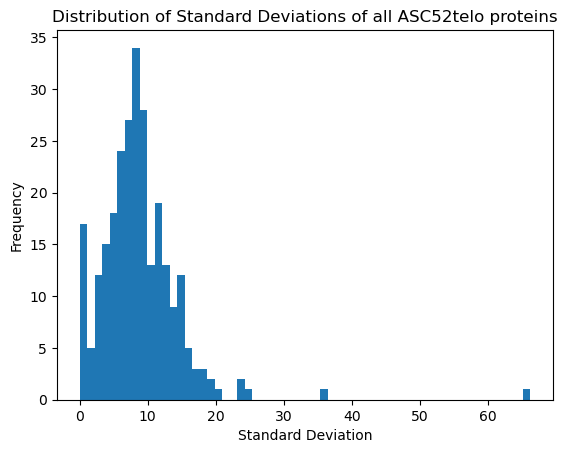

In [25]:
# Convert the AnnData object corresponding to ASC52telo to a DataFrame
df = pd.DataFrame(adata_ASC52telo.X, columns=adata_ASC52telo.var_names)

# Add a column for Ensembl IDs to the DataFrame
df["ensembl_id"] = adata_ASC52telo.obs["ensembl_id"].values

# Group the DataFrame by Ensembl ID, calculate the standard deviation for each group, and sum the results across all variables
df_tmp = df.groupby("ensembl_id").std().sum(axis=1)

# Plot a histogram of the summed standard deviations
plt.hist(df_tmp, bins=60)  # Create a histogram with specified number of bins

# add axis labels
plt.xlabel("Standard Deviation")  # X-axis label
plt.ylabel("Frequency")  # Y-axis label
plt.title("Distribution of Standard Deviations of all ASC52telo proteins")  # Title of the histogram

plt.show()  # Display the histogram

### Remove proteins with high standard deviation and aggregate to protein level

In [26]:
# Convert the AnnData object corresponding to ASC52telo to a DataFrame
df = pd.DataFrame(adata_ASC52telo.X, columns=adata_ASC52telo.var_names)

# Add a column for Ensembl IDs to the DataFrame
df["ensembl_id"] = adata_ASC52telo.obs["ensembl_id"].values

# Calculate the standard deviation for each Ensembl ID, summing across all variables
df_tmp = df.groupby("ensembl_id").std().sum(axis=1)

# Filter groups where the summed standard deviation is less than a threshold
df_tmp = df_tmp[df_tmp < 20]

# Keep only those proteins in the original DataFrame that meet the standard deviation criterion
num_ids_before = len(df["ensembl_id"].unique())
df = df[df["ensembl_id"].isin(df_tmp.index)]
num_ids_after = len(df["ensembl_id"].unique())

# print how many proteins were removed
print(f"Removed {num_ids_before - num_ids_after} proteins with high standard deviation.")

# Group by the Ensembl ID and compute the mean intensity for each group
df_grouped = df.groupby("ensembl_id").mean()

# Create a new AnnData object with the aggregated mean data
adata_ASC52telo_agg = AnnData(
    X=df_grouped.values,  # Values (means) as the main data
    var=adata_ASC52telo.var_names.values,  # Variable names from the original AnnData
    obs=pd.DataFrame(
        df_grouped.index
    ),  # Observation (indices) from the grouped DataFrame
)

# Prepare to map the subcellular location and other metadata to the aggregated data
df_unique = adata_ASC52telo.obs.drop_duplicates(
    subset="ensembl_id", keep="first"
).set_index(
    "ensembl_id"
)  # Select unique rows based on Ensembl ID

# Merge the aggregated observation data with the unique metadata based on Ensembl IDs
adata_ASC52telo_agg.obs = adata_ASC52telo_agg.obs.merge(
    df_unique, on="ensembl_id", how="left"
)

# Verify the shape of the original and aggregated AnnData objects
print(f"Original shape: {adata_ASC52telo.shape}")  # Print the shape of original data
print(
    f"Aggregated shape: {adata_ASC52telo_agg.shape}"
)  # Print the shape of aggregated data

Removed 6 proteins with high standard deviation.
Original shape: (2679, 100)
Aggregated shape: (259, 100)


### Check again for 0 rows and constant rows and remove them

In [27]:
# Check for zero vectors in the aggregated AnnData object
zero_vector_mask = np.all(
    adata_ASC52telo_agg.X == 0, axis=1
)  # Mask for rows where all elements are zero

# Add a column "zero_vector" to the observation DataFrame indicating whether each vector is zero
adata_ASC52telo_agg.obs["zero_vector"] = zero_vector_mask

# If any zero vectors are found, print the count and remove them from the AnnData object
if np.any(zero_vector_mask):
    print(f"Found {np.sum(zero_vector_mask)} zero vectors. Removing them.")
    adata_ASC52telo_agg = adata_ASC52telo_agg[
        ~adata_ASC52telo_agg.obs["zero_vector"]  # Keep rows that are not zero vectors
    ]

# Check for constant rows (i.e., rows with no variance, which means every value is the same)
constant_rows = (
    np.var(adata_ASC52telo_agg.X, axis=1) == 0
)  # Mask for rows with zero variance

# If any constant rows are found, print the count and remove them from the AnnData object
if np.any(constant_rows):
    print(f"Found {np.sum(constant_rows)} constant rows. Removing them.")
    adata_ASC52telo_agg = adata_ASC52telo_agg[
        ~constant_rows
    ]  # Keep rows that are not constant

In [28]:
len(adata_ASC52telo_agg.obs["ensembl_id"].unique())

259

### Scale each profile between 0-1 (max scaled)

In [29]:
# Create a copy of the aggregated AnnData object to avoid modifying the original data
adata_agg_ASC52telo_scaled = adata_ASC52telo_agg.copy()

# Scale each row (profile) of the AnnData object so that its values range from 0 to 1
# This is done by dividing each element in the row by the maximum value of that row
adata_agg_ASC52telo_scaled.X = (
    adata_ASC52telo_agg.X / adata_ASC52telo_agg.X.max(axis=1)[:, None]
)

In [30]:
# set input data
cilia_profiles = adata_agg_ASC52telo_scaled.X

## Determine number of clusters for range of cutoffs


Found 259 clusters for cutoff 0.00.
Found 159 clusters for cutoff 0.05.
Found 72 clusters for cutoff 0.10.
Found 38 clusters for cutoff 0.15.
Found 21 clusters for cutoff 0.20.
Found 12 clusters for cutoff 0.25.
Found 7 clusters for cutoff 0.30.
Found 5 clusters for cutoff 0.35.
Found 3 clusters for cutoff 0.40.
Found 2 clusters for cutoff 0.45.
Found 1 clusters for cutoff 0.50.
Found 1 clusters for cutoff 0.55.
Found 1 clusters for cutoff 0.60.
Found 1 clusters for cutoff 0.65.
Found 1 clusters for cutoff 0.70.
Found 1 clusters for cutoff 0.75.
Found 1 clusters for cutoff 0.80.
Found 1 clusters for cutoff 0.85.
Found 1 clusters for cutoff 0.90.
Found 1 clusters for cutoff 0.95.


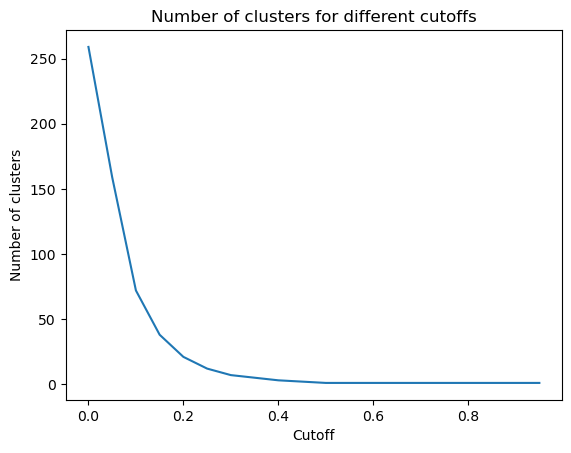

In [31]:
# Calculate the pairwise distance matrix using the Euclidean metric
distance_matrix = pdist(cilia_profiles, metric="euclidean")

# Perform hierarchical clustering using the average linkage method and Euclidean distance metric
linkage_matrix = linkage(
    cilia_profiles, method="average", metric="euclidean", optimal_ordering=True
)

# Scale the distance matrix to the range [0, 1]
distance_matrix_scaled = (distance_matrix - distance_matrix.min()) / (
    distance_matrix.max() - distance_matrix.min()
)

# Convert the scaled distance matrix to a square form
distance_matrix_square = squareform(distance_matrix_scaled)

# Initialize lists to store the number of clusters and labels for each cutoff
n_clusters = []
labels = {}

# Iterate through a range of cutoff thresholds to determine the number of clusters
for cutoff in np.arange(0, 1.0, 0.05):
    # Initialize the Agglomerative Clustering model with the specified parameters
    clusterer = cluster.AgglomerativeClustering(
        metric="precomputed",
        distance_threshold=cutoff,
        n_clusters=None,
        linkage="average",
    )

    # Fit the clustering model to the distance matrix
    clusterer.fit(distance_matrix_square)

    # Store the cluster labels and number of unique clusters for the current cutoff
    labels[f"{cutoff:.2f}"] = clusterer.labels_
    n_clusters.append(len(np.unique(clusterer.labels_)))
    print(f"Found {n_clusters[-1]} clusters for cutoff {cutoff:.2f}.")

# Plot the number of clusters for different cutoff thresholds
plt.plot(np.arange(0, 1.0, 0.05), n_clusters)
plt.xlabel("Cutoff")
plt.ylabel("Number of clusters")
plt.title("Number of clusters for different cutoffs")
plt.show()

## Cluster based on selected cutoff

In [32]:
# Set the cutoff threshold for clustering
cutoff = 0.16

# Initialize the Agglomerative Clustering model with the specified cutoff
clusterer = cluster.AgglomerativeClustering(
    metric="precomputed", distance_threshold=cutoff, n_clusters=None, linkage="average"
)

# Fit the clustering model to the distance matrix
clusterer.fit(distance_matrix_square)

# Retrieve the cluster labels
clusters = clusterer.labels_

# Count the number of unique clusters formed
n_clusters = len(np.unique(clusters))
print(f"Found {n_clusters} clusters for cutoff {cutoff}.")

Found 30 clusters for cutoff 0.16.


## Visualize clusters and heatmaps

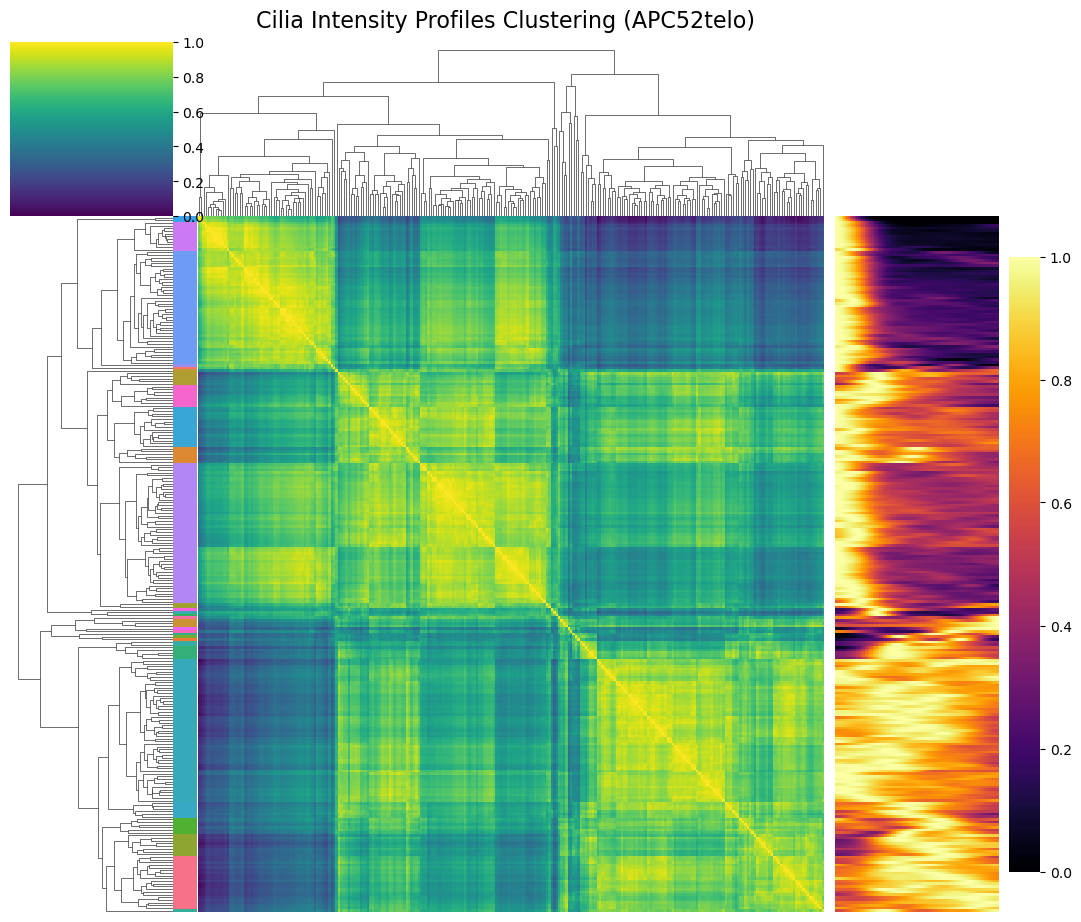

In [33]:
# Prepare vector with colors for each cluster
colors = sns.color_palette(
    "husl", n_clusters
)  # Generate a color palette with n_clusters colors
np.random.shuffle(colors)  # Shuffle the colors to randomize them
cluster_colors = [
    colors[cluster - 1] for cluster in clusters
]  # Assign colors to clusters

# Get the dendrogram order
dendro = dendrogram(linkage_matrix, no_plot=True)
dendro_order = dendro["leaves"]

# Reorder the matrix according to the dendrogram order
reordered_matrix = cilia_profiles[dendro_order, :]

# Create the first clustermap with row and column linkage
g = sns.clustermap(
    1 - distance_matrix_square,  # Plot the inverse of the distance matrix
    row_linkage=linkage_matrix,  # Use the precomputed row linkage
    col_linkage=linkage_matrix,  # Use the precomputed column linkage
    cmap="viridis",  # Use 'viridis' colormap
    row_colors=cluster_colors,  # Add colors to rows according to clusters
    xticklabels=False,  # Hide x-axis labels
    yticklabels=False,  # Hide y-axis labels
    figsize=(11, 9),  # Set figure size
    cbar_pos=(0.02, 0.8, 0.05, 0.1),  # Set colorbar position
)

# Set the gridspec to only cover a portion of the figure
g.gs.update(left=0.05, right=0.79)

# Create new gridspec for the right part of the figure
gs2 = mpl.gridspec.GridSpec(1, 1, left=0.8, top=0.79)

# Create axes within this new gridspec
ax2 = g.fig.add_subplot(gs2[0])

# Plot the second heatmap on the new axis
sns.heatmap(
    reordered_matrix,
    cmap="inferno",  # Use 'inferno' colormap
    cbar=True,  # Show colorbar
    xticklabels=False,  # Hide x-axis labels
    yticklabels=False,  # Hide y-axis labels
    ax=ax2,  # Specify the axis to plot on
)

# Set the title of the figure
plt.suptitle(
    "Cilia Intensity Profiles Clustering (APC52telo)", fontsize=16, y=1.02
)  

# Save the figure as an SVG image
plt.savefig(
    "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/APC52telo_agg_clustered.svg"
)

# Adjust layout to ensure both plots have the same height
plt.show()

## Plot without clustermap

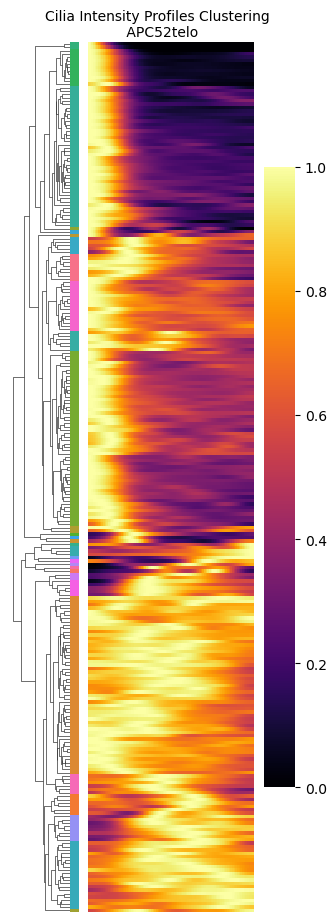

In [34]:
# Prepare a vector with colors for each cluster
colors = sns.color_palette(
    "husl", n_clusters
)  # Generate a color palette with n_clusters colors
np.random.shuffle(colors)  # Randomly shuffle the colors
cluster_colors = [
    colors[cluster - 1] for cluster in clusters
]  # Assign colors to clusters

# Get the order of rows for the dendrogram
dendro = dendrogram(linkage_matrix, no_plot=True)
dendro_order = dendro["leaves"]

# Reorder the cilia profiles matrix according to the dendrogram order
reordered_matrix = cilia_profiles[dendro_order, :]

# Create a clustermap with only the row dendrogram and row colors
g = sns.clustermap(
    1 - distance_matrix_square,  # Plot the inverse of the distance matrix
    row_linkage=linkage_matrix,  # Use the precomputed row linkage
    col_cluster=False,  # Disable column clustering
    cmap="viridis",  # Use 'viridis' colormap
    row_colors=cluster_colors,  # Add colors to rows according to clusters
    xticklabels=False,  # Hide x-axis labels
    yticklabels=False,  # Hide y-axis labels
    figsize=(6, 9),  # Set figure size
    cbar_pos=None,  # Disable the colorbar
    dendrogram_ratio=(0.2, 0.0),  # Set column dendrogram ratio to 0
    colors_ratio=(0.03, 0.0),  # Set column colors ratio to 0
)

# Remove the heatmap axis from the clustermap
g.ax_heatmap.remove()

# Set the gridspec to only cover a portion of the figure
g.gs.update(left=0.5, right=1)

# Create a new gridspec for the right part of the figure
gs2 = mpl.gridspec.GridSpec(1, 1, left=0.63)

# Create axes within this new gridspec
ax2 = g.fig.add_subplot(gs2[0])

# Plot the second heatmap on the new axis
sns.heatmap(
    reordered_matrix,  # Use the reordered matrix
    cmap="inferno",  # Use 'inferno' colormap
    cbar=True,  # Show colorbar
    xticklabels=False,  # Hide x-axis labels
    yticklabels=False,  # Hide y-axis labels
    ax=ax2,  # Specify the axis to plot on
    linewidths=0,  # Remove grid lines
    linecolor="none",  # Remove grid line colors
)

# Set the title of the figure
plt.suptitle(
    "Cilia Intensity Profiles Clustering \n APC52telo", fontsize=10, y=1.02, x=0.75 
)  

# Save the figure as an SVG image
plt.savefig(
    "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/APC52telo_agg_clustered.svg",
    bbox_inches="tight",  # Ensure the entire plot is saved
)

# Save the figure as a high-resolution PNG image
plt.savefig(
    "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/APC52telo_agg_clustered.png",
    bbox_inches="tight",  # Ensure the entire plot is saved
    dpi=1200,  # Set the resolution to 1200 DPI
)

# Adjust the layout to ensure both plots have the same height
plt.show()

## Count proteins in each cluster and add gene names to clusters

In [35]:
# Initialize an empty list to store cluster labels in dendrogram order
cluster_labels = []

# Append cluster labels according to the dendrogram order
for clstr in clusters[dendro_order]:
    cluster_labels.append(clstr)

# Convert the cluster labels into a DataFrame
df = pd.DataFrame(cluster_labels, columns=["cluster"])

# Count the number of proteins in each cluster
df_clusters = df["cluster"].value_counts(sort=False)

# Convert the series into a DataFrame and reset the index
df_clusters = df_clusters.reset_index()

# Rename the columns for clarity
df_clusters.columns = ["cluster", "protein_count"]

# Add a column containing the genes contained in each cluster
df_clusters["genes"] = df_clusters["cluster"].apply(
    lambda x: ", ".join(
        list(adata_ASC52telo_agg.obs["gene_name"].iloc[np.where(clusters == x)[0]])
    )
)

# Show dataframe
df_clusters

,cluster,protein_count,genes
0,15,2,"CDK18, CC2D2B"
1,14,11,"CROCC, NIN, CEP152, PCDHB15, CEP250, GLIS2, AD..."
2,8,42,"PRKAR2B, SDCCAG8, VASH1, GLI2, PIBF1, DNAL4, A..."
3,18,1,RRM1
4,27,1,MLF1
5,24,1,GIGYF1
6,1,5,"TTC23, TCTN2, ARL15, PPARA, EFCAB7"
7,5,8,"PCM1, PRPF6, SLC9A3R1, RAB11FIP5, RB1, LRRC46,..."
8,26,15,"KATNIP, FGFR1, RAB11A, CSPP1, PPL, LRAT, NECAB..."
9,0,6,"OFD1, RAB23, OCRL, FHDC1, MYOF, SHTN1"


## Perform functional enrichment analysis for clusters

In [36]:
# Initialize a dictionary to store enrichment results for each cluster
enrich_results = {}

# Iterate through each row in the df_clusters DataFrame
for idx, row in df_clusters.iterrows():

    # Skip clusters with fewer than 5 proteins
    if row["protein_count"] < 5:
        continue
    else:
        # Get the indices of the cluster
        cluster_indices = np.where(clusters == row["cluster"])[0]

        # Retrieve the corresponding protein names for the cluster
        protein_names = list(
            set(adata_ASC52telo_agg.obs["gene_name"].iloc[cluster_indices])
        )

        # Perform functional enrichment analysis using g:Profiler
        gp = GProfiler(return_dataframe=True)
        result = gp.profile(
            organism="hsapiens",  # Specify the organism as Homo sapiens
            query=protein_names,  # Input the list of protein names
            sources=[
                "GO:BP",
                "GO:MF",
            ],  # Specify GO Biological Process and Molecular Function
            no_evidences=False,  # Include evidence codes in the results
            user_threshold=0.05,  # Set the significance threshold for p-values
        )

        # Store the enrichment results for the current cluster
        enrich_results[row["cluster"]] = result

## Map enrichment results to DataFrame and save to .csv file

In [37]:
# Summarize each cluster’s enrichment results in one row

summary_rows = []
for cluster_id, df in enrich_results.items():
    summary_rows.append(
        {
            "cluster":            cluster_id,
            "Ontology":           join_with_semicolon(df["source"]),
            "GO term name":       join_with_semicolon(df["name"]),
            "GO term ID":         join_with_semicolon(df["native"]),
            "GO term p values":   join_with_semicolon(df["p_value"]),
            "term_size":          join_with_semicolon(df["term_size"]),
            "query_size":         join_with_semicolon(df["query_size"]),
            "intersection_size":  join_with_semicolon(df["intersection_size"]),
            "precision":          join_with_semicolon(df["precision"]),
            "recall":             join_with_semicolon(df["recall"]),
        }
    )

summary_df = pd.DataFrame(summary_rows)


# Merge with the clustering table (adds new cols)

df_cluster_unique = df_clusters.copy() # save unmodified version for later
df_clusters = df_clusters.merge(summary_df, on="cluster", how="left")


# Clusters with no enrichment → empty strings

fill_cols = [
    "Ontology", "GO term name", "GO term ID", "GO term p values",
    "term_size", "query_size", "intersection_size",
    "precision", "recall"
]
df_clusters[fill_cols] = df_clusters[fill_cols].fillna("")


# Save the enriched clustering CSV


df_clusters.to_csv(
    "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/ASC52telo_agg_clustered_enriched.csv",
    index=False,
    sep="\t",
)

# Display the DataFrame
df_clusters

,cluster,protein_count,genes,Ontology,GO term name,GO term ID,GO term p values,term_size,query_size,intersection_size,precision,recall
0,15,2,"CDK18, CC2D2B",,,,,,,,,
1,14,11,"CROCC, NIN, CEP152, PCDHB15, CEP250, GLIS2, AD...",GO:BP; GO:BP; GO:BP; GO:MF; GO:BP,centriole-centriole cohesion; centrosome cycle...,GO:0010457; GO:0007098; GO:0031023; GO:0051011...,6.20031029554825e-05; 0.0007477507730501498; 0...,15; 139; 155; 13; 663,11; 11; 11; 11; 11,3; 4; 4; 2; 5,0.2727272727272727; 0.36363636363636365; 0.363...,0.2; 0.02877697841726619; 0.025806451612903226...
2,8,42,"PRKAR2B, SDCCAG8, VASH1, GLI2, PIBF1, DNAL4, A...",GO:BP; GO:BP; GO:BP; GO:BP; GO:BP; GO:BP; GO:B...,cilium assembly; cilium organization; microtub...,GO:0060271; GO:0044782; GO:0007017; GO:0120036...,2.0975871153114745e-09; 4.591790146048829e-09;...,391; 418; 959; 1572; 590; 603; 1615; 998; 663;...,36; 36; 36; 36; 36; 36; 36; 36; 36; 36; 36; 36...,12; 12; 15; 17; 12; 12; 17; 14; 11; 5; 19; 11;...,0.3333333333333333; 0.3333333333333333; 0.4166...,0.030690537084398978; 0.028708133971291867; 0....
3,18,1,RRM1,,,,,,,,,
4,27,1,MLF1,,,,,,,,,
5,24,1,GIGYF1,,,,,,,,,
6,1,5,"TTC23, TCTN2, ARL15, PPARA, EFCAB7",GO:BP,smoothened signaling pathway,GO:0007224,0.0027673332303808583,151,5,3,0.6,0.019867549668874173
7,5,8,"PCM1, PRPF6, SLC9A3R1, RAB11FIP5, RB1, LRRC46,...",GO:BP; GO:BP; GO:BP; GO:BP; GO:BP,intraciliary transport involved in cilium asse...,GO:0035735; GO:0007098; GO:0031023; GO:0071539...,0.0012727003649764205; 0.004982400117859149; 0...,7; 139; 155; 36; 37,6; 6; 6; 6; 6,2; 3; 3; 2; 2,0.3333333333333333; 0.5; 0.5; 0.33333333333333...,0.2857142857142857; 0.02158273381294964; 0.019...
8,26,15,"KATNIP, FGFR1, RAB11A, CSPP1, PPL, LRAT, NECAB...",GO:BP; GO:BP; GO:BP; GO:BP; GO:BP,microtubule-based transport; microtubule-based...,GO:0099111; GO:0007017; GO:0007018; GO:0003351...,6.329305416766261e-06; 0.00011926156688796865;...,213; 959; 430; 43; 46,15; 15; 15; 15; 15,6; 8; 6; 3; 3,0.4; 0.5333333333333333; 0.4; 0.2; 0.2,0.028169014084507043; 0.008342022940563087; 0....
9,0,6,"OFD1, RAB23, OCRL, FHDC1, MYOF, SHTN1",GO:BP; GO:BP; GO:BP; GO:BP; GO:BP; GO:BP,plasma membrane bounded cell projection assemb...,GO:0120031; GO:0030031; GO:0060271; GO:0044782...,8.973705332011296e-05; 0.00010005263049534702;...,590; 603; 391; 418; 1572; 1615,6; 6; 6; 6; 6; 6,5; 5; 4; 4; 5; 5,0.8333333333333334; 0.8333333333333334; 0.6666...,0.00847457627118644; 0.008291873963515755; 0.0...


# hTERT_RPE1_serum_starved

## Avergage profiles per protein

### Remove proteins that are not in cilia

In [38]:
print(adata_hTERT_RPE1_serum_starved.shape)

# remove proteins that are not in cilia
adata_hTERT_RPE1_serum_starved = adata_hTERT_RPE1_serum_starved[
    adata_hTERT_RPE1_serum_starved.obs["loc_sum_hTERT_RPE1_serum_starved"] != 0
]

print(adata_hTERT_RPE1_serum_starved.shape)

(48678, 100)
(21445, 100)


### Visualize standard deviation per protein

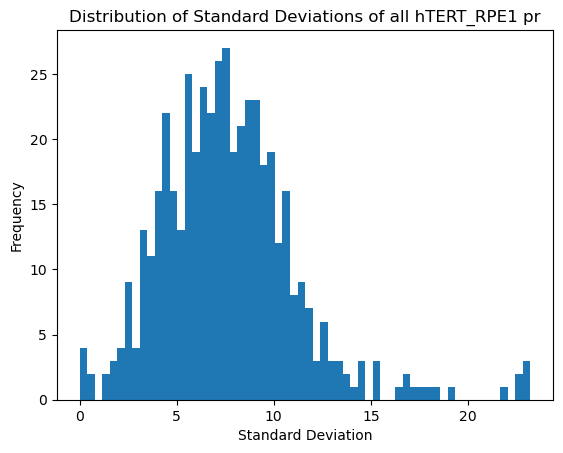

In [39]:
# Convert the AnnData object corresponding to hTERT_RPE1 to a DataFrame
df = pd.DataFrame(
    adata_hTERT_RPE1_serum_starved.X, columns=adata_hTERT_RPE1_serum_starved.var_names
)

# Add a column for Ensembl IDs to the DataFrame
df["ensembl_id"] = adata_hTERT_RPE1_serum_starved.obs["ensembl_id"].values

# Group the DataFrame by Ensembl ID, calculate the standard deviation for each group, and sum the results across all variables
df_tmp = df.groupby("ensembl_id").std().sum(axis=1)

# Plot a histogram of the summed standard deviations
plt.hist(df_tmp, bins=60)  # Create a histogram with specified number of bins

# add axis labels
plt.xlabel("Standard Deviation")  # X-axis label
plt.ylabel("Frequency")  # Y-axis label
plt.title("Distribution of Standard Deviations of all hTERT_RPE1 pr")  # Title of the histogram

plt.show()  # Display the histogram

### Remove proteins with high standard deviation and aggregate to protein level

In [40]:
# Convert the AnnData object corresponding to hTERT_RPE1 to a DataFrame
df = pd.DataFrame(
    adata_hTERT_RPE1_serum_starved.X, columns=adata_hTERT_RPE1_serum_starved.var_names
)

# Add a column for Ensembl IDs to the DataFrame
df["ensembl_id"] = adata_hTERT_RPE1_serum_starved.obs["ensembl_id"].values

# Uncomment the following lines to filter for proteins with low standard deviation between profiles
# Calculate the standard deviation for each Ensembl ID, summing across all variables
df_tmp = df.groupby("ensembl_id").std().sum(axis=1)

# Filter groups where the summed standard deviation is less than a threshold
df_tmp = df_tmp[df_tmp < 20]

# Keep only those proteins in the original DataFrame that meet the standard deviation criterion
num_ids_before = len(df["ensembl_id"].unique())
df = df[df["ensembl_id"].isin(df_tmp.index)]
num_ids_after = len(df["ensembl_id"].unique())

# print how many proteins were removed
print(f"Removed {num_ids_before - num_ids_after} proteins with high standard deviation.")

# Group by the Ensembl ID and compute the mean intensity for each group
df_grouped = df.groupby("ensembl_id").mean()

# Create a new AnnData object with the aggregated mean data
adata_hTERT_RPE1_serum_starved_agg = AnnData(
    X=df_grouped.values,  # Values (means) as the main data
    var=adata_hTERT_RPE1_serum_starved.var_names.values,  # Variable names from the original AnnData
    obs=pd.DataFrame(
        df_grouped.index
    ),  # Observation (indices) from the grouped DataFrame
)

# Prepare to map the subcellular location and other metadata to the aggregated data
df_unique = adata_hTERT_RPE1_serum_starved.obs.drop_duplicates(
    subset="ensembl_id", keep="first"
).set_index(
    "ensembl_id"
)  # Select unique rows based on Ensembl ID

# Merge the aggregated observation data with the unique metadata based on Ensembl IDs
adata_hTERT_RPE1_serum_starved_agg.obs = adata_hTERT_RPE1_serum_starved_agg.obs.merge(
    df_unique, on="ensembl_id", how="left"
)

# Verify the shape of the original and aggregated AnnData objects
print(
    f"Original shape: {adata_hTERT_RPE1_serum_starved.shape}"
)  # Print the shape of original data
print(
    f"Aggregated shape: {adata_hTERT_RPE1_serum_starved_agg.shape}"
)  # Print the shape of aggregated data

Removed 6 proteins with high standard deviation.
Original shape: (21445, 100)
Aggregated shape: (469, 100)


### Check again for 0 rows and constant rows and remove them

In [41]:
# Check for zero vectors in the aggregated AnnData object
zero_vector_mask = np.all(
    adata_hTERT_RPE1_serum_starved_agg.X == 0, axis=1
)  # Mask for rows where all elements are zero

# Add a column "zero_vector" to the observation DataFrame indicating whether each vector is zero
adata_hTERT_RPE1_serum_starved_agg.obs["zero_vector"] = zero_vector_mask

# If any zero vectors are found, print the count and remove them from the AnnData object
if np.any(zero_vector_mask):
    print(f"Found {np.sum(zero_vector_mask)} zero vectors. Removing them.")
    adata_hTERT_RPE1_serum_starved_agg = adata_hTERT_RPE1_serum_starved_agg[
        ~adata_hTERT_RPE1_serum_starved_agg.obs[
            "zero_vector"
        ]  # Keep rows that are not zero vectors
    ]

# Check for constant rows (i.e., rows with no variance, which means every value is the same)
constant_rows = (
    np.var(adata_hTERT_RPE1_serum_starved_agg.X, axis=1) == 0
)  # Mask for rows with zero variance

# If any constant rows are found, print the count and remove them from the AnnData object
if np.any(constant_rows):
    print(f"Found {np.sum(constant_rows)} constant rows. Removing them.")
    adata_hTERT_RPE1_serum_starved_agg = adata_hTERT_RPE1_serum_starved_agg[
        ~constant_rows
    ]  # Keep rows that are not constant

In [42]:
len(adata_hTERT_RPE1_serum_starved_agg.obs["ensembl_id"].unique())

469

### Scale each profile between 0-1 (max scaled)

In [43]:
# Create a copy of the aggregated AnnData object to avoid modifying the original data
adata_agg_hTERT_RPE1_serum_starved_agg_scaled = (
    adata_hTERT_RPE1_serum_starved_agg.copy()
)

# Scale each row (profile) of the AnnData object so that its values range from 0 to 1
# This is done by dividing each element in the row by the maximum value of that row
adata_agg_hTERT_RPE1_serum_starved_agg_scaled.X = (
    adata_hTERT_RPE1_serum_starved_agg.X
    / adata_hTERT_RPE1_serum_starved_agg.X.max(axis=1)[:, None]
)

In [44]:
# set input data
cilia_profiles = adata_agg_hTERT_RPE1_serum_starved_agg_scaled.X

## Determine number of clusters for range of cutoffs


Found 469 clusters for cutoff 0.00.
Found 197 clusters for cutoff 0.05.
Found 64 clusters for cutoff 0.10.
Found 30 clusters for cutoff 0.15.
Found 17 clusters for cutoff 0.20.
Found 12 clusters for cutoff 0.25.
Found 7 clusters for cutoff 0.30.
Found 6 clusters for cutoff 0.35.
Found 4 clusters for cutoff 0.40.
Found 3 clusters for cutoff 0.45.
Found 3 clusters for cutoff 0.50.
Found 2 clusters for cutoff 0.55.
Found 2 clusters for cutoff 0.60.
Found 2 clusters for cutoff 0.65.
Found 1 clusters for cutoff 0.70.
Found 1 clusters for cutoff 0.75.
Found 1 clusters for cutoff 0.80.
Found 1 clusters for cutoff 0.85.
Found 1 clusters for cutoff 0.90.
Found 1 clusters for cutoff 0.95.


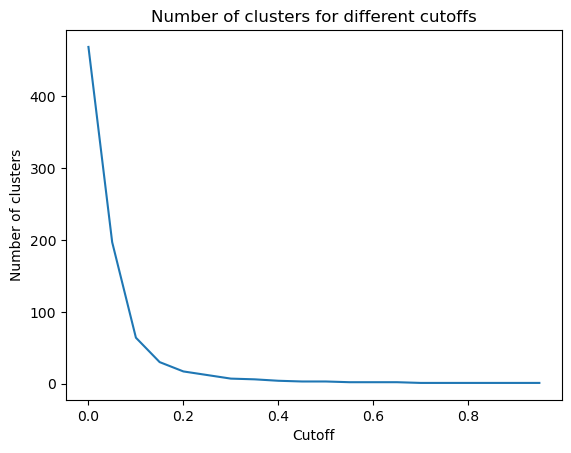

In [45]:
# Calculate the pairwise distance matrix using the Euclidean metric
distance_matrix = pdist(cilia_profiles, metric="euclidean")

# Perform hierarchical clustering using the average linkage method and Euclidean distance metric
linkage_matrix = linkage(
    cilia_profiles, method="average", metric="euclidean", optimal_ordering=True
)

# Scale the distance matrix to the range [0, 1]
distance_matrix_scaled = (distance_matrix - distance_matrix.min()) / (
    distance_matrix.max() - distance_matrix.min()
)

# Convert the scaled distance matrix to a square form
distance_matrix_square = squareform(distance_matrix_scaled)

# Initialize lists to store the number of clusters and labels for each cutoff
n_clusters = []
labels = {}

# Iterate through a range of cutoff thresholds to determine the number of clusters
for cutoff in np.arange(0, 1.0, 0.05):
    # Initialize the Agglomerative Clustering model with the specified parameters
    clusterer = cluster.AgglomerativeClustering(
        metric="precomputed",
        distance_threshold=cutoff,
        n_clusters=None,
        linkage="average",
    )

    # Fit the clustering model to the distance matrix
    clusterer.fit(distance_matrix_square)

    # Store the cluster labels and number of unique clusters for the current cutoff
    labels[f"{cutoff:.2f}"] = clusterer.labels_
    n_clusters.append(len(np.unique(clusterer.labels_)))
    print(f"Found {n_clusters[-1]} clusters for cutoff {cutoff:.2f}.")

# Plot the number of clusters for different cutoff thresholds
plt.plot(np.arange(0, 1.0, 0.05), n_clusters)
plt.xlabel("Cutoff")
plt.ylabel("Number of clusters")
plt.title("Number of clusters for different cutoffs")
plt.show()

## Cluster based on selected cutoff

In [46]:
# Set the cutoff threshold for clustering
cutoff = 0.16

# Initialize the Agglomerative Clustering model with the specified cutoff
clusterer = cluster.AgglomerativeClustering(
    metric="precomputed", distance_threshold=cutoff, n_clusters=None, linkage="average"
)

# Fit the clustering model to the distance matrix
clusterer.fit(distance_matrix_square)

# Retrieve the cluster labels
clusters = clusterer.labels_

# Count the number of unique clusters formed
n_clusters = len(np.unique(clusters))
print(f"Found {n_clusters} clusters for cutoff {cutoff}.")

Found 25 clusters for cutoff 0.16.


## Visualize clusters and heatmaps

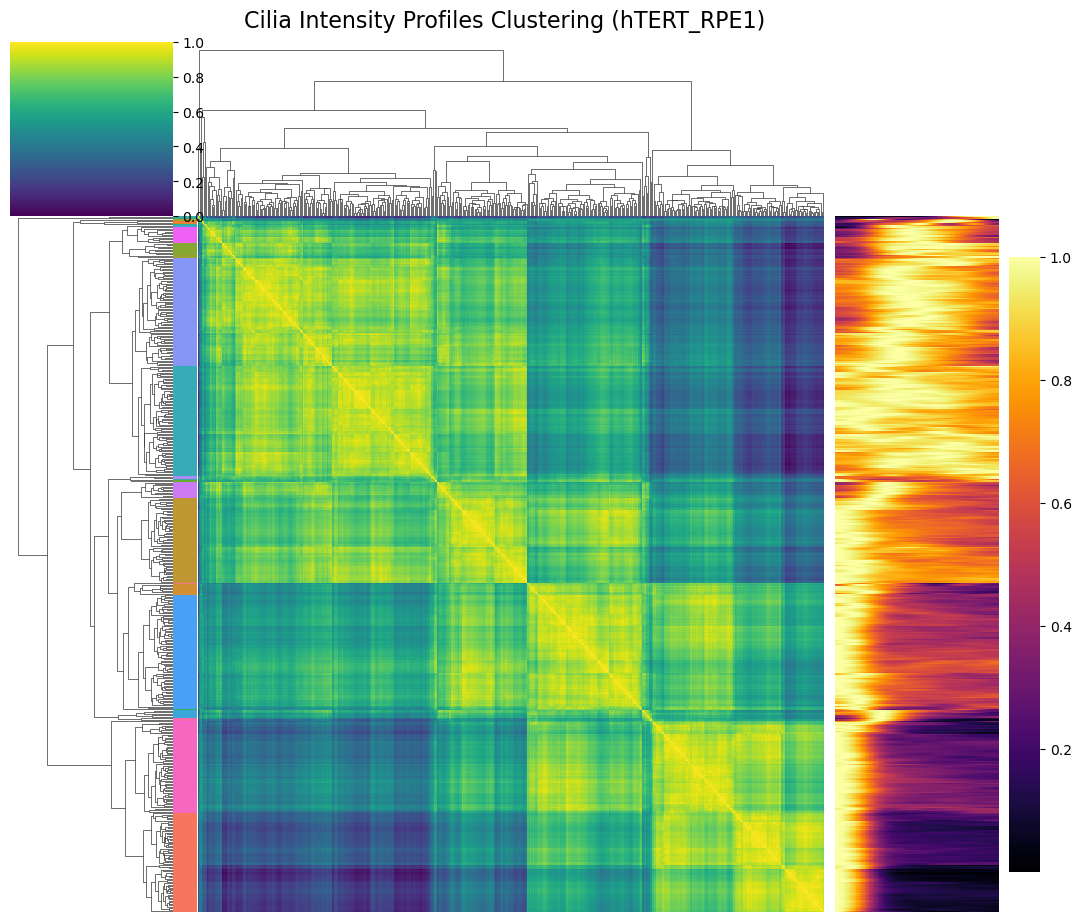

In [47]:
# Prepare vector with colors for each cluster
colors = sns.color_palette(
    "husl", n_clusters
)  # Generate a color palette with n_clusters colors
np.random.shuffle(colors)  # Shuffle the colors to randomize them
cluster_colors = [
    colors[cluster - 1] for cluster in clusters
]  # Assign colors to clusters

# Get the dendrogram order
dendro = dendrogram(linkage_matrix, no_plot=True)
dendro_order = dendro["leaves"]

# Reorder the matrix according to the dendrogram order
reordered_matrix = cilia_profiles[dendro_order, :]

# Create the first clustermap with row and column linkage
g = sns.clustermap(
    1 - distance_matrix_square,  # Plot the inverse of the distance matrix
    row_linkage=linkage_matrix,  # Use the precomputed row linkage
    col_linkage=linkage_matrix,  # Use the precomputed column linkage
    cmap="viridis",  # Use 'viridis' colormap
    row_colors=cluster_colors,  # Add colors to rows according to clusters
    xticklabels=False,  # Hide x-axis labels
    yticklabels=False,  # Hide y-axis labels
    figsize=(11, 9),  # Set figure size
    cbar_pos=(0.02, 0.8, 0.05, 0.1),  # Set colorbar position
)

# Set the gridspec to only cover a portion of the figure
g.gs.update(left=0.05, right=0.79)

# Create new gridspec for the right part of the figure
gs2 = mpl.gridspec.GridSpec(1, 1, left=0.8, top=0.79)

# Create axes within this new gridspec
ax2 = g.fig.add_subplot(gs2[0])

# Plot the second heatmap on the new axis
sns.heatmap(
    reordered_matrix,
    cmap="inferno",  # Use 'inferno' colormap
    cbar=True,  # Show colorbar
    xticklabels=False,  # Hide x-axis labels
    yticklabels=False,  # Hide y-axis labels
    ax=ax2,  # Specify the axis to plot on
)

# Set the title of the figure
plt.suptitle(
    "Cilia Intensity Profiles Clustering (hTERT_RPE1)", fontsize=16, y=1.02
)  

# Save the figure as an SVG image
plt.savefig(
    "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/hTERT_RPE1_serum_starved_agg_clustered.svg"
)

# Adjust layout to ensure both plots have the same height
plt.show()

## Plot without clustermap

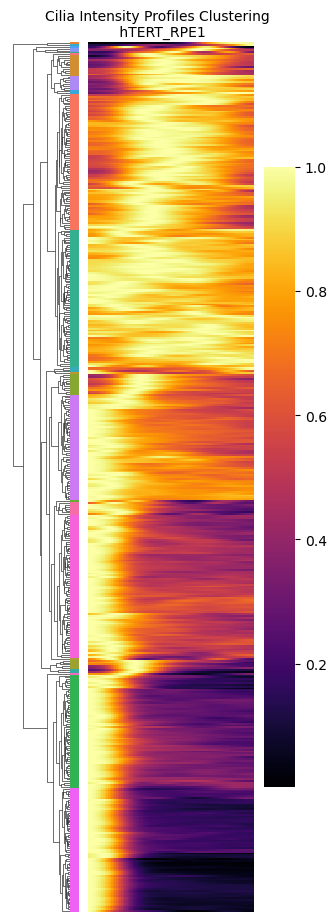

In [48]:
# Prepare a vector with colors for each cluster
colors = sns.color_palette(
    "husl", n_clusters
)  # Generate a color palette with n_clusters colors
np.random.shuffle(colors)  # Randomly shuffle the colors
cluster_colors = [
    colors[cluster - 1] for cluster in clusters
]  # Assign colors to clusters

# Get the order of rows for the dendrogram
dendro = dendrogram(linkage_matrix, no_plot=True)
dendro_order = dendro["leaves"]

# Reorder the cilia profiles matrix according to the dendrogram order
reordered_matrix = cilia_profiles[dendro_order, :]

# Create a clustermap with only the row dendrogram and row colors
g = sns.clustermap(
    1 - distance_matrix_square,  # Plot the inverse of the distance matrix
    row_linkage=linkage_matrix,  # Use the precomputed row linkage
    col_cluster=False,  # Disable column clustering
    cmap="viridis",  # Use 'viridis' colormap
    row_colors=cluster_colors,  # Add colors to rows according to clusters
    xticklabels=False,  # Hide x-axis labels
    yticklabels=False,  # Hide y-axis labels
    figsize=(6, 9),  # Set figure size
    cbar_pos=None,  # Disable the colorbar
    dendrogram_ratio=(0.2, 0.0),  # Set column dendrogram ratio to 0
    colors_ratio=(0.03, 0.0),  # Set column colors ratio to 0
)

# Remove the heatmap axis from the clustermap
g.ax_heatmap.remove()

# Set the gridspec to only cover a portion of the figure
g.gs.update(left=0.5, right=1)

# Create a new gridspec for the right part of the figure
gs2 = mpl.gridspec.GridSpec(1, 1, left=0.63)

# Create axes within this new gridspec
ax2 = g.fig.add_subplot(gs2[0])

# Plot the second heatmap on the new axis
sns.heatmap(
    reordered_matrix,  # Use the reordered matrix
    cmap="inferno",  # Use 'inferno' colormap
    cbar=True,  # Show colorbar
    xticklabels=False,  # Hide x-axis labels
    yticklabels=False,  # Hide y-axis labels
    ax=ax2,  # Specify the axis to plot on
    linewidths=0,  # Remove grid lines
    linecolor="none",  # Remove grid line colors
)

# Set the title of the figure
plt.suptitle(
    "Cilia Intensity Profiles Clustering \n hTERT_RPE1", fontsize=10, y=1.02, x=0.75 
)  

# Save the figure as an SVG image
plt.savefig(
    "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/hTERT_RPE1_serum_starved_agg_clustered.svg",
    bbox_inches="tight",  # Ensure the entire plot is saved
)

# Save the figure as a high-resolution PNG image
plt.savefig(
    "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/hTERT_RPE1_serum_starved_agg_clustered.png",
    bbox_inches="tight",  # Ensure the entire plot is saved
    dpi=1200,  # Set the resolution to 1200 DPI
)

# Adjust the layout to ensure both plots have the same height
plt.show()

## Count proteins in each cluster and add gene names to clusters

In [49]:
# Initialize an empty list to store cluster labels in dendrogram order
cluster_labels = []

# Append cluster labels according to the dendrogram order
for clstr in clusters[dendro_order]:
    cluster_labels.append(clstr)

# Convert the cluster labels into a DataFrame
df = pd.DataFrame(cluster_labels, columns=["cluster"])

# Count the number of proteins in each cluster
df_clusters = df["cluster"].value_counts(sort=False)

# Convert the series into a DataFrame and reset the index
df_clusters = df_clusters.reset_index()

# Rename the columns for clarity
df_clusters.columns = ["cluster", "protein_count"]

# Add a column containing the genes contained in each cluster
df_clusters["genes"] = df_clusters["cluster"].apply(
    lambda x: ", ".join(
        list(
            adata_hTERT_RPE1_serum_starved_agg.obs["gene_name"].iloc[
                np.where(clusters == x)[0]
            ]
        )
    )
)

# Show dataframe
df_clusters

,cluster,protein_count,genes
0,19,1,FAM149B1
1,12,1,LPAR3
2,21,1,MNS1
3,3,2,"VHL, CCDC14"
4,15,1,ODAD4
5,18,1,ANO10
6,1,11,"WDR47, SNX10, PPP2R3C, RUNDC3B, DDC, CHRM3, CF..."
7,20,8,"SYNE2, CRX, RAB34, ACVR1B, GPR161, CDC42EP5, C..."
8,4,2,"DNALI1, RSL1D1"
9,0,73,"IFT88, PHLPP2, MAPK6, TPD52, TULP3, RPGRIP1, S..."


## Perform functional enrichment analysis for clusters

In [50]:
# Initialize a dictionary to store enrichment results for each cluster
enrich_results = {}

# Iterate through each row in the df_clusters DataFrame
for idx, row in df_clusters.iterrows():

    # Skip clusters with fewer than 5 proteins
    if row["protein_count"] < 5:
        continue
    else:
        # Get the indices of the cluster
        cluster_indices = np.where(clusters == row["cluster"])[0]

        # Retrieve the corresponding protein names for the cluster
        protein_names = list(
            set(
                adata_hTERT_RPE1_serum_starved_agg.obs["gene_name"].iloc[
                    cluster_indices
                ]
            )
        )

        # Perform functional enrichment analysis using g:Profiler
        gp = GProfiler(return_dataframe=True)
        result = gp.profile(
            organism="hsapiens",  # Specify the organism as Homo sapiens
            query=protein_names,  # Input the list of protein names
            sources=[
                "GO:BP",
                "GO:MF",
            ],  # Specify GO Biological Process and Molecular Function
            no_evidences=False,  # Include evidence codes in the results
            user_threshold=0.05,  # Set the significance threshold for p-values
        )

        # Store the enrichment results for the current cluster
        enrich_results[row["cluster"]] = result

## Map enrichment results to DataFrame and save to .csv file

In [51]:
# Summarize each cluster’s enrichment results in one row

summary_rows = []
for cluster_id, df in enrich_results.items():
    summary_rows.append(
        {
            "cluster":            cluster_id,
            "Ontology":           join_with_semicolon(df["source"]),
            "GO term name":       join_with_semicolon(df["name"]),
            "GO term ID":         join_with_semicolon(df["native"]),
            "GO term p values":   join_with_semicolon(df["p_value"]),
            "term_size":          join_with_semicolon(df["term_size"]),
            "query_size":         join_with_semicolon(df["query_size"]),
            "intersection_size":  join_with_semicolon(df["intersection_size"]),
            "precision":          join_with_semicolon(df["precision"]),
            "recall":             join_with_semicolon(df["recall"]),
        }
    )

summary_df = pd.DataFrame(summary_rows)


# Merge with the clustering table (adds new cols)

df_cluster_unique = df_clusters.copy() # save unmodified version for later
df_clusters = df_clusters.merge(summary_df, on="cluster", how="left")


# Clusters with no enrichment → empty strings

fill_cols = [
    "Ontology", "GO term name", "GO term ID", "GO term p values",
    "term_size", "query_size", "intersection_size",
    "precision", "recall"
]
df_clusters[fill_cols] = df_clusters[fill_cols].fillna("")


# Save the enriched clustering CSV


df_clusters.to_csv(
    "/home/groups/emmalu/konstantin/cilia/Cilia_intensity_profiles_Paul/revision/hTERT_RPE1_serum_starved_agg_clustered_enriched.csv",
    index=False,
    sep="\t",
)

# Display the DataFrame
df_clusters

,cluster,protein_count,genes,Ontology,GO term name,GO term ID,GO term p values,term_size,query_size,intersection_size,precision,recall
0,19,1,FAM149B1,,,,,,,,,
1,12,1,LPAR3,,,,,,,,,
2,21,1,MNS1,,,,,,,,,
3,3,2,"VHL, CCDC14",,,,,,,,,
4,15,1,ODAD4,,,,,,,,,
5,18,1,ANO10,,,,,,,,,
6,1,11,"WDR47, SNX10, PPP2R3C, RUNDC3B, DDC, CHRM3, CF...",GO:BP,developmental process,GO:0032502,0.027791943624682094,6478,9,9,1.0,0.001389317690645261
7,20,8,"SYNE2, CRX, RAB34, ACVR1B, GPR161, CDC42EP5, C...",GO:BP; GO:BP; GO:BP; GO:BP,plasma membrane bounded cell projection assemb...,GO:0120031; GO:0030031; GO:0060271; GO:0044782,0.0009323640882207283; 0.001038447634543397; 0...,590; 603; 391; 418,8; 8; 8; 8,5; 5; 4; 4,0.625; 0.625; 0.5; 0.5,0.00847457627118644; 0.008291873963515755; 0.0...
8,4,2,"DNALI1, RSL1D1",,,,,,,,,
9,0,73,"IFT88, PHLPP2, MAPK6, TPD52, TULP3, RPGRIP1, S...",GO:BP; GO:BP; GO:BP; GO:BP; GO:BP; GO:BP; GO:B...,cilium organization; cilium assembly; plasma m...,GO:0044782; GO:0060271; GO:0120031; GO:0030031...,1.483547438967378e-11; 9.273241064586874e-11; ...,418; 391; 590; 603; 1572; 1615; 959; 430; 998;...,66; 66; 66; 66; 66; 66; 66; 66; 66; 66; 66; 66...,17; 16; 17; 17; 24; 24; 19; 13; 18; 29; 5; 6; ...,0.25757575757575757; 0.24242424242424243; 0.25...,0.04066985645933014; 0.04092071611253197; 0.02...
